Proposed models:
- quadratic regression
- quadratic regression with weighted least squares
- quartic regression with fixing coefficients to have 0 at the boundary (doesn't address heteroskedacity): $(ax + bx^2)(cy + dy^2)$
- fit log(1 + std)

Do a 5-fold split with 5 generated dataframes, compute rmse for each model (new notebook).

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from utils import simulate_gbm

# ---- will call all of this from utils later ------

def mean_diff(S0, mu, sigma, T, N, n_paths, leverage):
    return simulate_gbm(S0, mu, sigma, T, int(N), n_paths, leverage).mean()
def std_diff(S0, mu, sigma, T, N, n_paths, leverage):
    return simulate_gbm(S0, mu, sigma, T, int(N), n_paths, leverage).std()

def lev_sigma_std(
    mu=0,
    sigmas=np.linspace(0.01, 0.4, 100),
    T=5,
    freq=1,
    n_paths=10000,
    factors=np.linspace(1.01, 3, 100),
):
    factor, sigma = np.meshgrid(factors, sigmas, indexing="ij")

    std = np.vectorize(std_diff)(1, mu, sigma, T, T * freq, n_paths, factor)

    return pd.DataFrame(
        {"factor": factor.ravel(), "sigma": sigma.ravel(), "std": std.ravel()}
    )

In [6]:
for i in range(1,6):
    df = lev_sigma_std()
    df.to_csv(f"output/lev_sigma_std_{i}.csv")

/Users/aleksandarmilivojevic/Desktop/leveraged etf/Leveraged-ETFs/utils.py:21: RuntimeWarning: invalid value encountered in log
  np.cumsum(np.log((np.exp(drift + diffusion) - 1) * leverage + 1), axis=1)
/Users/aleksandarmilivojevic/Desktop/leveraged etf/Leveraged-ETFs/utils.py:21: RuntimeWarning: invalid value encountered in log
  np.cumsum(np.log((np.exp(drift + diffusion) - 1) * leverage + 1), axis=1)
/Users/aleksandarmilivojevic/Desktop/leveraged etf/Leveraged-ETFs/utils.py:21: RuntimeWarning: invalid value encountered in log
  np.cumsum(np.log((np.exp(drift + diffusion) - 1) * leverage + 1), axis=1)
/Users/aleksandarmilivojevic/Desktop/leveraged etf/Leveraged-ETFs/utils.py:21: RuntimeWarning: invalid value encountered in log
  np.cumsum(np.log((np.exp(drift + diffusion) - 1) * leverage + 1), axis=1)
/Users/aleksandarmilivojevic/Desktop/leveraged etf/Leveraged-ETFs/utils.py:21: RuntimeWarning: invalid value encountered in log
  np.cumsum(np.log((np.exp(drift + diffusion) - 1) * lev

quadratic regression:

In [35]:
df = pd.read_csv("output/lev_sigma_std.csv")

In [36]:
# 1. Prepare your features (X) and target (y)
# df has columns ['factor', 'sigma', 'std']
X = df[["factor", "sigma"]]
z = df["std"]

# 2. Create a pipeline: Polynomial Expansion -> Linear Regression
model = Pipeline(
    [("poly", PolynomialFeatures(degree=2)), ("linear", LinearRegression())]
)

# 3. Fit the model
model.fit(X, z)

# 4. Predict values (e.g., to see how well it fits)
df["std_fitted"] = model.predict(X)

In [37]:

print(f"mse = {mean_squared_error(z,df["std_fitted"])}")

mse = 0.14021809217618966


In [39]:
z.var()

np.float64(1.8313238618181842)

In [38]:
model.score(X,z)

0.9234258241748117

transform by log(1+x)

In [135]:
df = pd.read_csv("output/lev_sigma_std.csv")

In [136]:
df["log1_std"] = np.log(1 + df["std"])

In [63]:
# plot

# reshape into matrix form
pivot = df.pivot(index="sigma", columns="factor", values="log1_std")

X = pivot.columns.values          # factor values
Y = pivot.index.values            # sigma values
Z = pivot.values                  # std values

X, Y = np.meshgrid(X, Y)

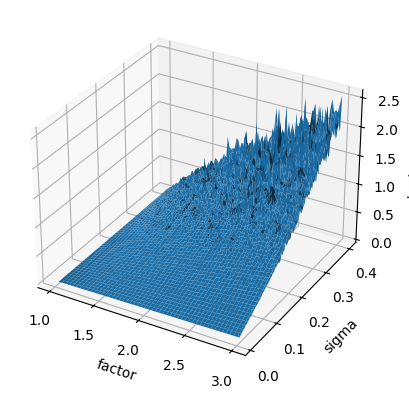

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot_surface(X, Y, Z)

ax.set_xlabel("factor")
ax.set_ylabel("sigma")
ax.set_zlabel("log(1+std)")

plt.show()

In [137]:
# df has columns ['factor', 'sigma', 'std']
X = df[["factor", "sigma"]]
z = df["log1_std"]

# 2. Create a pipeline: Polynomial Expansion -> Linear Regression
model = Pipeline(
    [("poly", PolynomialFeatures(degree=2)), ("linear", LinearRegression(fit_intercept = False))]
)

# 3. Fit the model
model.fit(X, z)

# 4. Predict values (e.g., to see how well it fits)
df["log1_std_fitted"] = model.predict(X)

In [139]:
print(f"mse = {mean_squared_error(z,df["log1_std_fitted"])}")

mse = 0.0024700427054672133


In [140]:
# Access the coefficients
coefficients = model.named_steps["linear"].coef_
intercept = model.named_steps["linear"].intercept_

# Get the feature names in the correct order
feature_names = model.named_steps["poly"].get_feature_names_out()

# Display coefficients with their corresponding feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coef_df)
print(f"Intercept: {intercept}")

        Feature  Coefficient
0             1     0.008461
1        factor     0.088443
2         sigma    -4.063031
3      factor^2    -0.038847
4  factor sigma     2.823781
5       sigma^2     3.673638
Intercept: 0.0


In [141]:
z.var()   #baseline to compare mse to

np.float64(0.25190694355744564)

In [142]:
model.score(X, z)    #R2

0.9901936417489924

In [143]:
# compare on original scale

df["std_fitted"] = np.exp(df["log1_std_fitted"]) - 1

print("original-scale mse = ", mean_squared_error(df["std"], df["std_fitted"]))

r2_original_scale = 1 - ((df["std"] - df["std_fitted"])**2).sum() / ((df["std"] - df["std"].mean())**2).sum()
print("original-scale R^2 = ", r2_original_scale)

original-scale mse =  0.06092421516268859
original-scale R^2 =  0.966728818717507


Now address the growing residuals.

In [75]:
df["residual"] = df["std"] - df["std_fitted"]

In [76]:
# plot

# reshape into matrix form
pivot = df.pivot(index="sigma", columns="factor", values="residual")

X = pivot.columns.values          # factor values
Y = pivot.index.values            # sigma values
R = pivot.values                  # residual values

X, Y = np.meshgrid(X, Y)

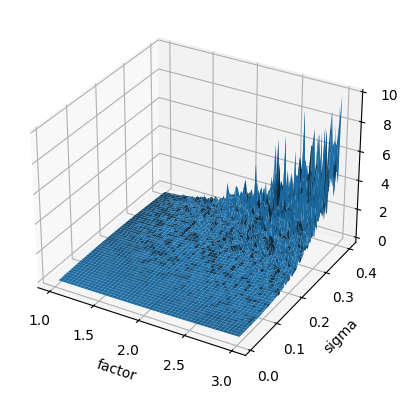

In [77]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot_surface(X, Y, R)

ax.set_xlabel("factor")
ax.set_ylabel("sigma")
ax.set_zlabel("residuals")

plt.show()

In [78]:
df["residual_transformed"] = np.log(1 + (df["std"] - df["std_fitted"])**2)

In [79]:
# reshape into matrix form
pivot = df.pivot(index="sigma", columns="factor", values="residual_transformed")

X = pivot.columns.values          # factor values
Y = pivot.index.values            # sigma values
R = pivot.values                  # transformed residual values

X, Y = np.meshgrid(X, Y)

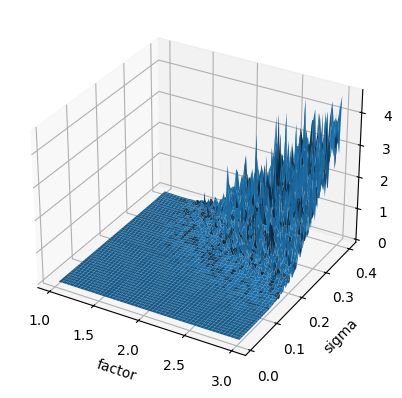

In [80]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.plot_surface(X, Y, R)

ax.set_xlabel("factor")
ax.set_ylabel("sigma")
ax.set_zlabel("log(1+residual^2)")

plt.show()

Weighted least squares:

In [110]:
# Step 0: define weights as exponential in both inputs
# you can tune alpha and beta to match how fast residuals grow
alpha = 5   # coefficient for factor
beta = 5    # coefficient for sigma

X = df[["factor", "sigma"]]
z = df["log1_std"]

weights = 1 / np.exp(alpha * X["factor"] + beta * X["sigma"])
#weights = 1/np.exp(np.exp(X["factor"] + X["sigma"]))


# Step 1: create pipeline
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2)),
    ("linear", LinearRegression(fit_intercept=False))
])

# Step 2: fit with WLS weights
model.fit(X, z, linear__sample_weight=weights)

# Step 3: predict
df["log1_std_fitted_wls"] = model.predict(X)

In [111]:
mean_squared_error(z,df["log1_std_fitted_wls"])

0.0037711636873057806

In [112]:
z.var()

np.float64(0.25190694355744564)

In [109]:
model.score(X,z)

0.9842685580777485

quartic regression (without restrictions):

In [115]:
df = pd.read_csv("output/lev_sigma_std.csv")

In [116]:
# 1. Prepare your features (X) and target (y)
# df has columns ['factor', 'sigma', 'std']
X = df[["factor", "sigma"]]
z = df["std"]

# 2. Create a pipeline: Polynomial Expansion -> Linear Regression
model = Pipeline(
    [("poly", PolynomialFeatures(degree=4)), ("linear", LinearRegression(fit_intercept = False))]
)

# 3. Fit the model
model.fit(X, z)

# 4. Predict values (e.g., to see how well it fits)
df["std_fitted"] = model.predict(X)

In [117]:
print(f"mse = {mean_squared_error(z,df["std_fitted"])}")

mse = 0.05921878460049463


In [118]:
z.var()

np.float64(1.8313238618181842)

In [119]:
model.score(X,z)

0.9676601674307885

quartic regression with log(1+x) pre-transformation:

In [130]:
df = pd.read_csv("output/lev_sigma_std.csv")
df["log1_std"] = np.log(1 + df["std"])

In [131]:
# df has columns ['factor', 'sigma', 'std']
X = df[["factor", "sigma"]]
z = df["log1_std"]

# 2. Create a pipeline: Polynomial Expansion -> Linear Regression
model = Pipeline(
    [("poly", PolynomialFeatures(degree=4)), ("linear", LinearRegression(fit_intercept = False))]
)

# 3. Fit the model
model.fit(X, z)

# 4. Predict values (e.g., to see how well it fits)
df["log1_std_fitted"] = model.predict(X)

In [132]:
print(f"mse = {mean_squared_error(z,df["log1_std_fitted"])}")
print(z.var())
print(model.score(X,z))

mse = 0.0020343249130745696
0.25190694355744564
0.9919234923135527


In [133]:
# see the coefficients

coefficients = model.named_steps["linear"].coef_
intercept = model.named_steps["linear"].intercept_

# Get the feature names in the correct order
feature_names = model.named_steps["poly"].get_feature_names_out()

# Display coefficients with their corresponding feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coef_df)
print(f"Intercept: {intercept}")

             Feature  Coefficient
0                  1     0.055857
1             factor    -0.208399
2              sigma    -0.588249
3           factor^2     0.187286
4       factor sigma     1.538996
5            sigma^2   -14.586033
6           factor^3    -0.059216
7     factor^2 sigma    -0.384264
8     factor sigma^2    10.805251
9            sigma^3    17.366573
10          factor^4     0.006046
11    factor^3 sigma     0.115852
12  factor^2 sigma^2    -1.548390
13    factor sigma^3    -3.522921
14           sigma^4   -10.495809
Intercept: 0.0


In [134]:
# compare on original scale

df["std_fitted"] = np.exp(df["log1_std_fitted"]) - 1

print("original-scale mse = ", mean_squared_error(df["std"], df["std_fitted"]))

r2_original_scale = 1 - ((df["std"] - df["std_fitted"])**2).sum() / ((df["std"] - df["std"].mean())**2).sum()
print("original-scale R^2 = ", r2_original_scale)

original-scale mse =  0.05904791269299239
original-scale R^2 =  0.9677534818903251


Now create a consolidated procedure for outputting mse and r2:

In [145]:
dfs = [pd.read_csv(f"output/lev_sigma_std_{i}.csv") for i in range(1,6)]

In [146]:
# now make general function, input is degree of polynomial, and boolean whether to preprocess with log(1+x) or not. include graphing of residuals and original

In [176]:
def model_evaluate(df, degree = 2, take_log = False, plot = False):

    def plot_surface():

        df_copy = df.copy()
        df_copy["z"] = z
        df_copy["z_hat"] = z_hat

        # reshape into matrix form
        pivot_org = df_copy.pivot(index="sigma", columns="factor", values="z")
        pivot_hat = df_copy.pivot(index="sigma", columns="factor", values="z_hat")

        X = pivot.columns.values          # factor values
        Y = pivot.index.values            # sigma values
        Z_org = pivot_org.values                  # original std values
        Z_hat = pivot_hat.values                   # fitted std values

        X, Y = np.meshgrid(X, Y)

        fig = plt.figure(figsize = (8,6))
        plt.tight_layout()
        ax = fig.add_subplot(projection="3d")

        ax.plot_surface(X, Y, Z_org, alpha = 0.6)
        ax.plot_wireframe(X, Y, Z_hat)

        ax.set_xlabel("factor")
        ax.set_ylabel("sigma")
        ax.set_zlabel("std")
        plt.title("mesh grid is the fitted values")

        plt.show()


    X = df[["factor", "sigma"]]
    z = np.log(1 + df["std"]) if take_log else df["std"]
    
    model = Pipeline(
    [("poly", PolynomialFeatures(degree=degree)), ("linear", LinearRegression(fit_intercept = False))]
    )   

    model.fit(X, z)

    z_hat = model.predict(X)

    if take_log:
        z_hat = np.exp(z_hat) - 1
    

    mse = mean_squared_error(df["std"], z_hat)
    print("original-scale" if take_log else "", "mse = ", mse)

    r2 = 1 - ((df["std"] - z_hat)**2).sum() / ((df["std"] - df["std"].mean())**2).sum()

    print("original-scale" if take_log else "", "R^2 = ", r2)

    if plot:
        plot_surface()

    return mse, r2

In [156]:
df = pd.read_csv("output/lev_sigma_std_1.csv")

 mse =  0.07782161603233043
 R^2 =  0.9588447698933271


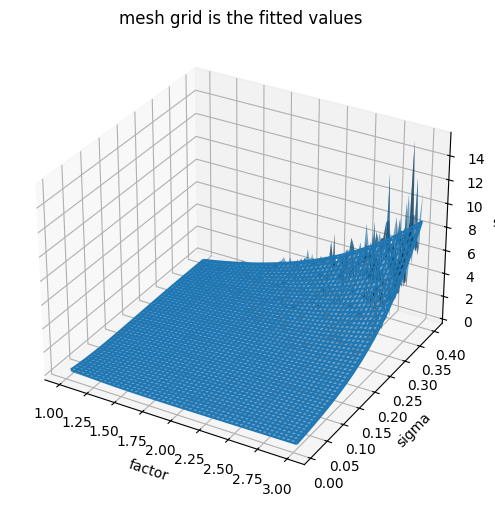

(0.07782161603233043, np.float64(0.9588447698933271))

In [181]:
model_evaluate(df, degree = 4, take_log = False, plot = True)